# DCGAN

In [1]:
# pip install gdown

## Dataset

In [2]:
import torchvision.transforms as T
from torchvision.datasets.celeba import CelebA
from torch.utils.data import DataLoader
from torchvision.utils import make_grid

transform = T.Compose(
    [
        T.Resize(64),
        T.CenterCrop(64),
        T.ToTensor(),
        T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ]
)
dataset = CelebA(
    "./datasets", download=True, transform=transform
)
loader = DataLoader(dataset, batch_size=128, shuffle=True)

Files already downloaded and verified


## Generator

In [3]:
import torch
import torch.nn as nn


class Generator(nn.Module):
    def __init__(self, num_channel=3, latent_dim=100, feature_dim=64):
        super().__init__()

        self.layer_1 = nn.Sequential(
            nn.ConvTranspose2d(latent_dim, feature_dim * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(feature_dim * 8),
            nn.ReLU(True),
        )
        self.layer_2 = nn.Sequential(
            nn.ConvTranspose2d(feature_dim * 8, feature_dim * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_dim * 4),
            nn.ReLU(True),
        )
        self.layer_3 = nn.Sequential(
            nn.ConvTranspose2d(feature_dim * 4, feature_dim * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_dim * 2),
            nn.ReLU(True),
        )
        self.layer_4 = nn.Sequential(
            nn.ConvTranspose2d(feature_dim * 2, feature_dim, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_dim),
            nn.ReLU(True),
        )
        self.last_layer = nn.Sequential(
            nn.ConvTranspose2d(feature_dim, num_channel, 4, 2, 1, bias=False),
            nn.Tanh(),
        )

    def forward(self, z):
        # decoding
        layer_1_out = self.layer_1(z)  # (N, 512, 4, 4)
        layer_2_out = self.layer_2(layer_1_out)  # (N, 256, 8, 8)
        layer_3_out = self.layer_3(layer_2_out)  # (N, 128, 16, 16)
        layer_4_out = self.layer_4(layer_3_out)  # (N, 64, 32, 32)
        # transform to rgb
        out = self.last_layer(layer_4_out)  # (N, 3, 64, 64)
        return out

In [4]:
latent_dim = 100
generator = Generator(latent_dim=latent_dim)

z = torch.rand(128, latent_dim, 1, 1) # (N, 100, 1, 1)

with torch.no_grad():
    # decoding
    layer_1_out = generator.layer_1(z)  # (N, 512, 4, 4)
    layer_2_out = generator.layer_2(layer_1_out)  # (N, 256, 8, 8)
    layer_3_out = generator.layer_3(layer_2_out)  # (N, 128, 16, 16)
    layer_4_out = generator.layer_4(layer_3_out)  # (N, 64, 32, 32)
    # transform to rgb
    out = generator.last_layer(layer_4_out)  # (N, 3, 64, 64)

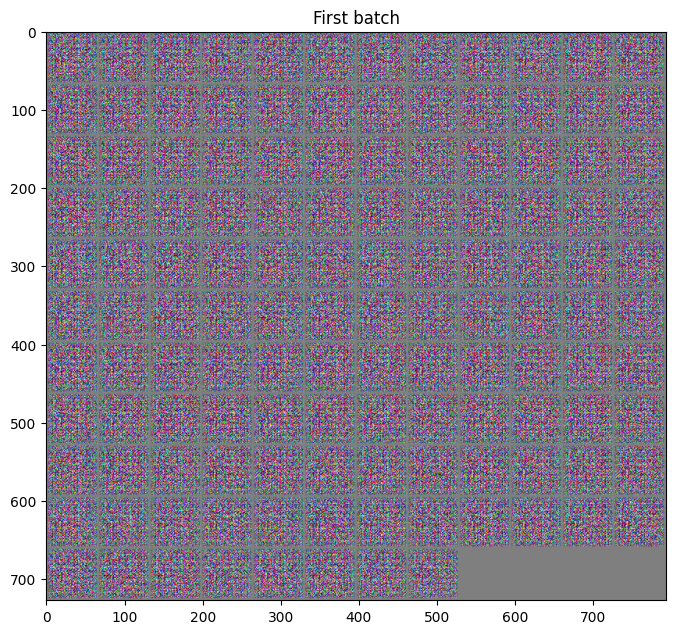

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from torchvision.utils import make_grid


out_x_grid = make_grid(out, nrow=12).numpy()

plt.figure(figsize=(8, 8))
plt.title("First batch")

# make data range to 0~1
out_x_grid = (out_x_grid * 0.5) + 0.5
plt.imshow(np.transpose(out_x_grid, (1, 2, 0)))

## Discriminator

In [6]:
class Discriminator(nn.Module):
    def __init__(self, num_channel=3, feature_dim=64):
        super().__init__()
        self.layer_1 = nn.Sequential(
            nn.Conv2d(num_channel, feature_dim, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_dim),
            nn.LeakyReLU(0.2, inplace=True),
        )
        self.layer_2 = nn.Sequential(
            nn.Conv2d(feature_dim, feature_dim * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_dim * 2),
            nn.LeakyReLU(0.2, inplace=True),
        )
        self.layer_3 = nn.Sequential(
            nn.Conv2d(feature_dim * 2, feature_dim * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_dim * 4),
            nn.LeakyReLU(0.2, inplace=True),
        )
        self.layer_4 = nn.Sequential(
            nn.Conv2d(feature_dim * 4, feature_dim * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_dim * 8),
            nn.LeakyReLU(0.2, inplace=True),
        )

        self.last_layer = nn.Sequential(
            nn.Conv2d(feature_dim * 8, 1, 4, 1, 0, bias=False), nn.Sigmoid()
        )

    def forward(self, x):
        # encoding
        layer_1_out = self.layer_1(x)  # (N, 64, 32, 32)
        layer_2_out = self.layer_2(layer_1_out)  # (N, 128, 16, 16)
        layer_3_out = self.layer_3(layer_2_out)  # (N, 256, 8, 8)
        layer_4_out = self.layer_4(layer_3_out)  # (N, 512, 4, 4)
        # classify
        out = self.last_layer(layer_4_out).squeeze()  # (N)
        return out


In [7]:
discriminator = Discriminator()

In [8]:
for batch in loader:
    x = batch[0]
    break
    
with torch.no_grad():
    # encoding
    layer_1_out = discriminator.layer_1(x)  # (N, 64, 32, 32)
    layer_2_out = discriminator.layer_2(layer_1_out)  # (N, 128, 16, 16)
    layer_3_out = discriminator.layer_3(layer_2_out)  # (N, 256, 8, 8)
    layer_4_out = discriminator.layer_4(layer_3_out)  # (N, 512, 4, 4)
    # classify
    out = discriminator.last_layer(layer_4_out).squeeze()  # (N)

In [9]:
out[:10]

tensor([0.3556, 0.4582, 0.2960, 0.5108, 0.5106, 0.3993, 0.4445, 0.3980, 0.3183,
        0.5106])

## Train

### Weight initailization

In [10]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find("BatchNorm") != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [11]:
_ = generator.apply(weights_init)
_ = discriminator.apply(weights_init)

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [13]:
_ = discriminator.to(device)
_ = generator.to(device)

### Logger

In [ ]:
from torch.utils.tensorboard import SummaryWriter

# tensorboard logger
writer = SummaryWriter()

### Loss

In [ ]:
# loss function
bce_loss_fn = nn.BCELoss()

### Optimizer

In [ ]:
import torch.optim as optim


# optimizer
discriminator_opt = optim.Adam(
    discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999)
)
generator_opt = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))

### Code

In [14]:
from tqdm import tqdm


# meta data
n_epochs = 5

# for visualization
iteration = 0
fixed_z = torch.randn((64, latent_dim, 1, 1)).to(device)

# for iteration history
G_loss_history = []
D_loss_history = []

# train code
for epoch in range(n_epochs):
    epoch_G_loss = 0.0
    epoch_D_loss = 0.0

    for batch in tqdm(loader, desc=f"Epoch {epoch + 1}/{n_epochs}"):
        generator.train()
        discriminator.train()

        x = batch[0].to(device)
        batch_size = x.size(0)

        #
        # 1. get discriminator loss from real data
        #
        discriminator_opt.zero_grad()
        real_D_score = discriminator(x)
        real_target = torch.ones_like(real_D_score).to(device)
        real_D_loss = bce_loss_fn(real_D_score, real_target)
        #
        # 2. get discriminator loss from fake data
        #
        z = torch.randn((batch_size, latent_dim, 1, 1)).to(device)
        fake_data = generator(z)

        fake_D_score = discriminator(fake_data)
        fake_target = torch.zeros_like(fake_D_score).to(device)
        fake_D_loss = bce_loss_fn(fake_D_score, fake_target)
        #
        # 3. get discriminator loss and update discriminator
        #
        D_loss = real_D_loss + fake_D_loss
        D_loss.backward()
        discriminator_opt.step()

        #
        # 4. get generator loss and update generator
        #
        generator_opt.zero_grad()
        z = torch.randn((batch_size, latent_dim, 1, 1)).to(device)
        generated_data = generator(z)

        generate_D_score = discriminator(generated_data)
        generate_target = torch.ones_like(generate_D_score).to(device)

        G_loss = bce_loss_fn(generate_D_score, generate_target)

        G_loss.backward()
        generator_opt.step()

        # iteration logging
        G_loss_history += [G_loss.item()]
        D_loss_history += [D_loss.item()]

        epoch_D_loss += D_loss.item() * len(x) / len(loader.dataset)
        epoch_G_loss += G_loss.item() * len(x) / len(loader.dataset)

        writer.add_scalar("Loss/generator", G_loss, iteration)
        writer.add_scalar("Loss/discriminator", D_loss, iteration)

        # iteration checkpoint
        if iteration % 1000 == 0:
            # visualization
            with torch.no_grad():
                generated_x = generator(fixed_z)
                generated_x = generated_x.detach().cpu()
                generated_x_grid = make_grid(generated_x, nrow=8).numpy()
                generated_x_grid = (generated_x_grid * 0.5) + 0.5
                generated_x_grid = np.transpose(generated_x_grid, (1, 2, 0))
                plt.imsave(f"dcgan-step-{iteration}.png", generated_x_grid)
            # model save
            torch.save(generator, f"dcgan-generator-step-{iteration}.pt")
        iteration += 1
    log_string = f"Loss at epoch {epoch + 1} - D_loss : {epoch_D_loss:.4f}, G_loss : {epoch_G_loss:.4f}"
    print(log_string)

# save last model
with torch.no_grad():
    generated_x = generator(fixed_z)
    generated_x = generated_x.detach().cpu()
    generated_x_grid = make_grid(generated_x, nrow=8).numpy()
    generated_x_grid = (generated_x_grid * 0.5) + 0.5
    generated_x_grid = np.transpose(generated_x_grid, (1, 2, 0))
    plt.imsave(f"dcgan-step-{iteration}.png", generated_x_grid)
torch.save(generator, f"dcgan-generator-step-{iteration}.pt")

Epoch 1/5: 100%|██████████| 1272/1272 [03:20<00:00,  6.34it/s]


Loss at epoch 1 - D_loss : 0.6342, G_loss : 7.3766


Epoch 2/5: 100%|██████████| 1272/1272 [03:18<00:00,  6.41it/s]


Loss at epoch 2 - D_loss : 0.6417, G_loss : 3.8137


Epoch 3/5: 100%|██████████| 1272/1272 [03:18<00:00,  6.42it/s]


Loss at epoch 3 - D_loss : 0.6967, G_loss : 2.9740


Epoch 4/5: 100%|██████████| 1272/1272 [03:17<00:00,  6.44it/s]


Loss at epoch 4 - D_loss : 0.7547, G_loss : 2.5252


Epoch 5/5: 100%|██████████| 1272/1272 [03:18<00:00,  6.41it/s]


Loss at epoch 5 - D_loss : 0.7395, G_loss : 2.4700


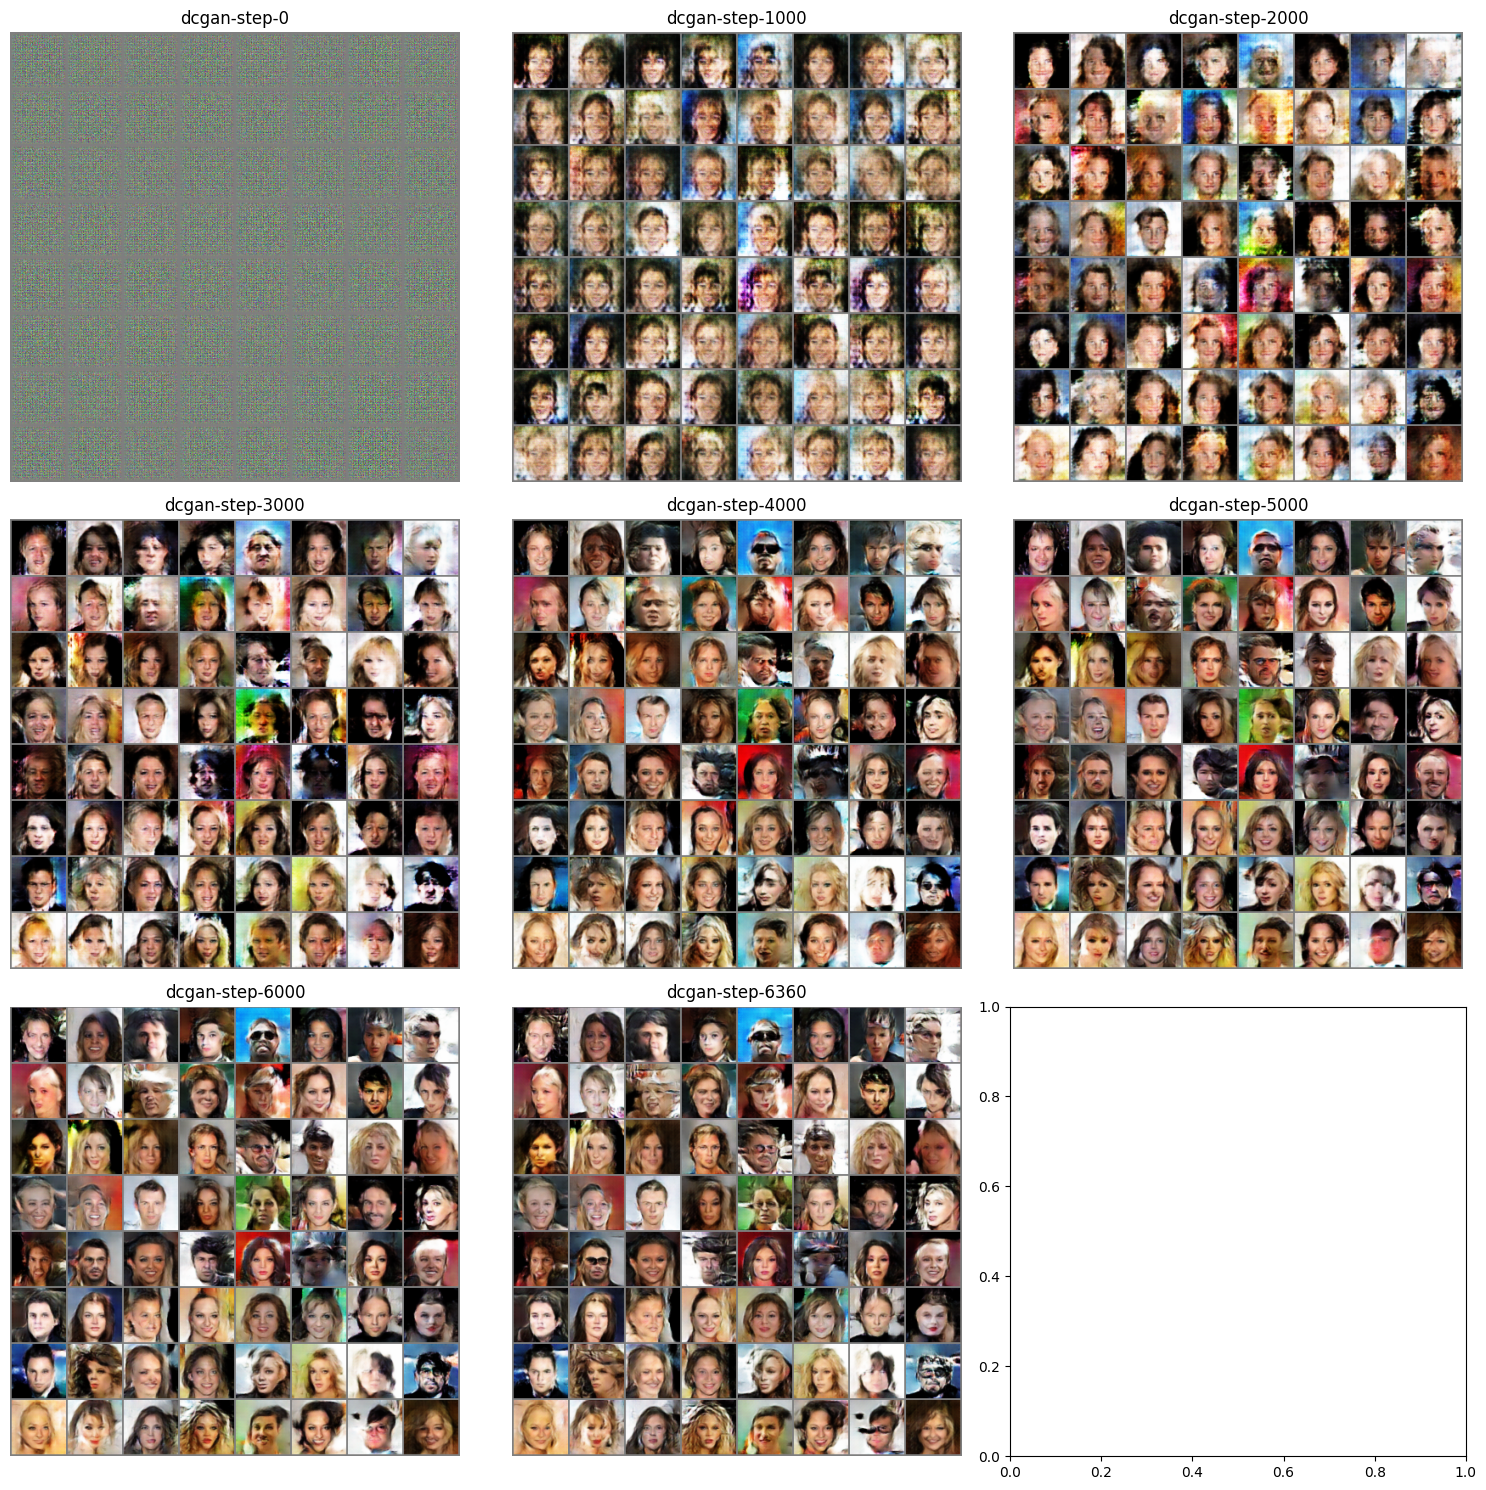

In [54]:
import os

img_list = list(sorted(filter(lambda x: x.startswith("dcgan-step"), os.listdir("."))))
nrows = (len(img_list) // 3) + 1

fig, axes = plt.subplots(ncols=3, nrows=nrows, figsize=(5 * nrows, 15))
for idx, fname in enumerate(img_list):
    array = plt.imread(fname)
    axes[idx // 3, idx % 3].imshow(array)
    axes[idx // 3, idx % 3].axis("off")
    axes[idx // 3, idx % 3].set_title(fname.replace(".png", ""))

plt.tight_layout()

## Generation

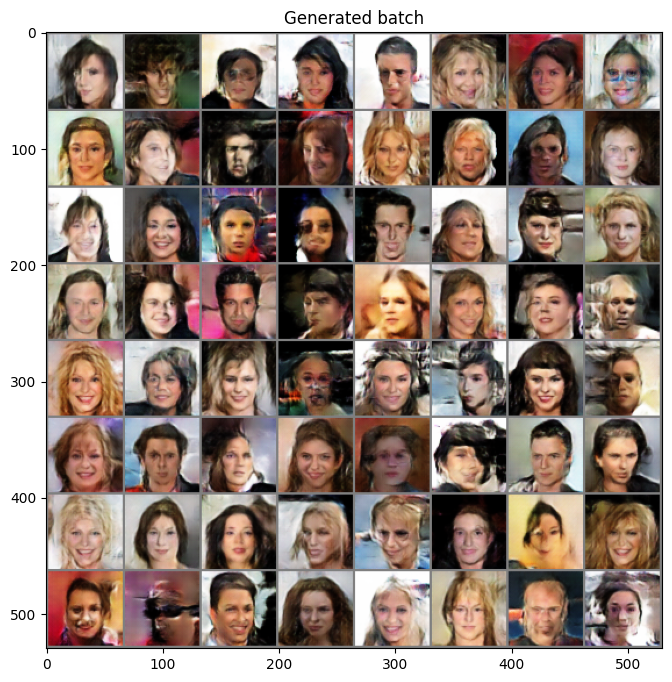

In [16]:
generator.eval()
with torch.no_grad():    
    random_z = torch.randn((64, latent_dim, 1, 1)).to(device)
    generated_x = generator(random_z)

generated_x_grid = make_grid(generated_x, nrow=8).cpu().numpy()
# make data range to 0~1
generated_x_grid = (generated_x_grid * 0.5) + 0.5
plt.figure(figsize=(8, 8))
plt.title("Generated batch")
plt.imshow(np.transpose(generated_x_grid, (1, 2, 0)))